In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from gaia_download import vari_class, vari_short_timescale
import gPhoton
from download_isochrone import load_isochrone
from extinction import add_colors_and_abs_mag
import plotly.graph_objects as go
from simbad_download import fetch_catalog_id
import pyvo as vo

from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, ICRS
import astropy.units as u
from download_lightcurves import download_dr3_lightcurve

In [49]:
CLUSTER_NAME: str = 'King 11'

In [50]:
bss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')

bss_candidates = add_colors_and_abs_mag(bss_candidates)
yss_candidates = add_colors_and_abs_mag(yss_candidates)

In [51]:
sources = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}.csv')
clustered = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_clustered.csv')
found = pd.read_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_found.csv')
isochrone = load_isochrone(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_isochrone.dat')

In [52]:
bss_candidates = pd.concat([bss_candidates,
                           clustered[np.isclose(clustered['BP-RP'], 0.6, 1e-2) & np.isclose(clustered['G_abs'], 3.75, .1)],
                           clustered[(clustered['BP-RP']<=0.66) & (clustered['G_abs']<=3.7)]])

In [53]:
yss_candidates = pd.concat([yss_candidates,
                            clustered[np.isclose(clustered['BP-RP'], 1.075, 1e-2) & np.isclose(clustered['G_abs'], 2.13, .01)]])

In [54]:
TO_COLOR = np.min(isochrone[:, 0])

In [55]:
yss_candidates = yss_candidates[yss_candidates['BP-RP']<1.25]

In [56]:
yss_candidates = yss_candidates[~(np.isclose(yss_candidates['BP-RP'], 1.07, .01))]

In [57]:
bss_candidates = bss_candidates[~((bss_candidates['BP-RP']>0.7) & (bss_candidates['G_abs']>2.75) |
                                  (bss_candidates['BP-RP']<0.35))]

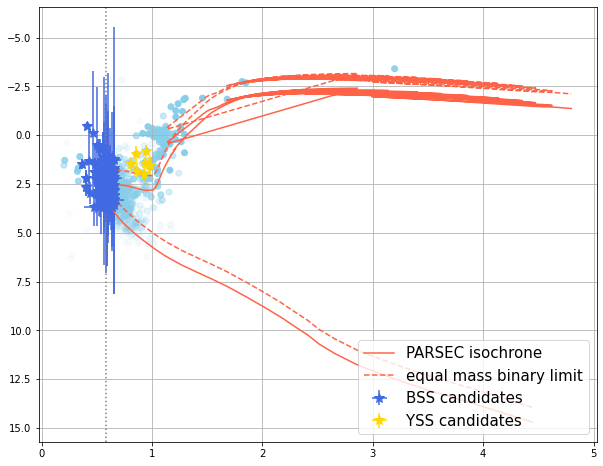

In [58]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.scatter(clustered['BP-RP'], clustered['G_abs'], color='skyblue', alpha=clustered['occurences'])
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.grid();

In [59]:
bss_candidates = bss_candidates[~((bss_candidates.G_abs<1.9)&(bss_candidates['BP-RP']>0.62))]
bss_candidates = bss_candidates[~((bss_candidates.G_abs>2.) & (bss_candidates['BP-RP']>0.6))]

In [60]:
np.quantile(bss_candidates.G_abs_error, [.5])

array([0.79170383])

In [61]:
bss_candidates = bss_candidates[bss_candidates.G_abs_error<np.quantile(bss_candidates.G_abs_error, [.5])[0]]

In [62]:
len(bss_candidates)

44

In [63]:
yss_candidates = yss_candidates[yss_candidates.G_abs_error<np.quantile(yss_candidates.G_abs_error, [.5])[0]]

In [64]:
yss_candidates = yss_candidates[(yss_candidates.G_abs<2)&(yss_candidates['BP-RP']<=1.)&
                                (yss_candidates.G_abs>.5)]

In [65]:
len(yss_candidates)

4

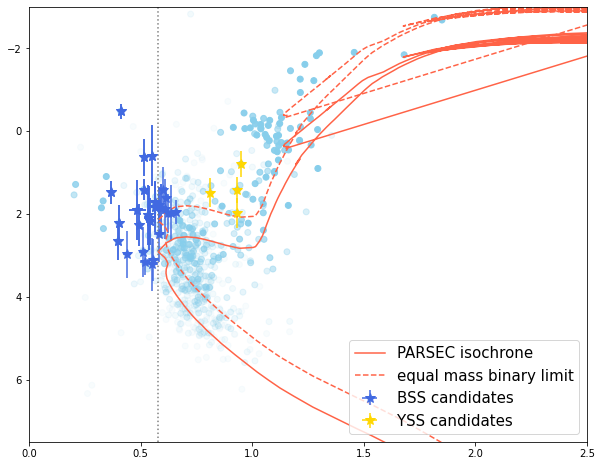

In [66]:
plt.figure(figsize=(10, 8))
TO_COLOR = np.min(isochrone[:, 0])
plt.scatter(clustered['BP-RP'], clustered['G_abs'], color='skyblue', alpha=clustered['occurences'])
plt.errorbar(bss_candidates['BP-RP'], bss_candidates['G_abs'],
             xerr=bss_candidates['BP-RP_error'], yerr=bss_candidates['G_abs_error'],
             color='royalblue', fmt='*', zorder=2, label='BSS candidates', markersize=10.)
plt.errorbar(yss_candidates['BP-RP'], yss_candidates['G_abs'],
             xerr=yss_candidates['BP-RP_error'], yerr=yss_candidates['G_abs_error'],
             color='gold', fmt='*', zorder=2, label='YSS candidates', markersize=10.)

plt.plot(isochrone[:, 0], isochrone[:, 1], color='tomato', label='PARSEC isochrone')
plt.plot(isochrone[:, 0], isochrone[:, 1]-0.75, color='tomato', label='equal mass binary limit',
         linestyle='--')
plt.axvline(x=TO_COLOR, color='gray', linestyle='dotted')
plt.gca().invert_yaxis();
plt.legend(fontsize=15, loc='lower right');
plt.gca().set_xlim(0, 2.5);
plt.gca().set_ylim(7.5, -3.);

# BSS variability

In [67]:
bss_candidates = add_colors_and_abs_mag(bss_candidates).drop_duplicates(subset=['source_id'])

In [68]:
bss_candidates.head()

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier
3,4.0,42174,1636148068921376768,Gaia DR3 2211125476959735680,2211125476959735680,460212261,2016.0,-3.101076,0.048254,68.615038,...,1.395744,0.900538,0.583240,0.008098,1.772845,0.416810,0.134613,0,0.80,1.0
5,9.0,42408,1636148068921376768,Gaia DR3 2211126340249961472,2211126340249961472,1089664623,2016.0,-3.175045,0.068789,68.625377,...,1.410283,0.909918,0.486171,0.036404,1.908070,0.725434,0.354368,0,0.60,-1.0
6,10.0,42414,1636148068921376768,Gaia DR3 2211126340254321536,2211126340254321536,597032443,2016.0,-3.153921,0.060250,68.636279,...,1.395605,0.900448,0.494921,0.011103,2.264067,0.505869,0.133526,0,0.80,-1.0
7,14.0,42514,1636148068921376768,Gaia DR3 2211126580772483968,2211126580772483968,965772321,2016.0,-3.102761,0.034413,68.664846,...,1.410283,0.909918,0.513604,0.003829,1.412117,0.258362,0.132060,0,0.95,-1.0
11,19.0,51329,1636148068921376768,Gaia DR3 2211219180267501056,2211219180267501056,1465739074,2016.0,-2.993500,0.062805,68.621377,...,1.395744,0.900538,0.544109,0.013248,2.179338,0.557901,0.114509,0,0.70,1.0


In [69]:
bss_var = bss_candidates[bss_candidates.phot_variable_flag=='VARIABLE']

In [73]:
bss_var

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier
21,62.0,41672,1636148068921376768,Gaia DR3 2211122217085752704,2211122217085752704,1519358746,2016.0,-3.148045,0.044406,68.561474,...,1.264893,0.816112,0.566417,0.017684,1.708331,0.502783,0.12062,0,0.1,1.0


In [70]:
bss_classes = vari_class(bss_var.source_id.values)

INFO: Query finished. [astroquery.utils.tap.core]


In [71]:
bss_classes

,source_id,in_vari_rrlyrae,in_vari_cepheid,in_vari_planetary_transit,in_vari_short_timescale,in_vari_long_period_variable,in_vari_eclipsing_binary,in_vari_rotation_modulation,in_vari_ms_oscillator,in_vari_agn,in_vari_microlensing,in_vari_compact_companion
0,2211122217085752704,false,false,false,false,false,true,false,false,false,false,false


In [74]:
def mag_error(flux_over_error: float) -> float:
    return 1/(flux_over_error*2.5/np.log(10))


def gaia_time_to_bjd(tcb_time: float) -> float:
    return tcb_time + 2455197.5

def load_dr3_lightcurve(lc1: pd.DataFrame) -> pd.DataFrame:
    lc1['mag_error'] = mag_error(lc1.flux_error.values)
    lc1['time'] = gaia_time_to_bjd(lc1['time'])
    return lc1
    
def get_gaia_bands(lc1: pd.DataFrame):
    lc_dict = {}
    for band in ['G', 'BP', 'RP']:
        lc_dict[band] = lc1[lc1.band==band]
    return lc_dict

def plot(lcs: pd.DataFrame, band: str):
    lc = lcs[band]
    plt.figure(figsize=(10, 7))
    plt.errorbar(lc.time, lc.mag, yerr=lc.mag_error, fmt='o', color=COLORS[band], label=band);
    plt.gca().set_xlabel('time [JD]', fontsize=16);
    plt.gca().set_ylabel('mag', fontsize=16);
    plt.legend(fontsize=16);

COLORS = {
    'G': 'black',
    'BP': 'royalblue',
    'RP': 'indianred'
}

In [75]:
lc = get_gaia_bands(load_dr3_lightcurve(download_dr3_lightcurve([2211122217085752704])[0]))

len['EPOCH_PHOTOMETRY-Gaia DR3 2211122217085752704.xml'] lightcurves found.


In [76]:
np.any(bss_candidates.non_single_star)

False

In [77]:
bss_candidates[bss_candidates.ruwe>1.4][['source_id', 'has_epoch_photometry', 'ruwe', 'excess', 'occurences']]

,source_id,has_epoch_photometry,ruwe,excess,occurences
644,2211220142333927680,False,1.406762,0.389687,0.1


In [78]:
np.any(bss_candidates.has_epoch_rv)

False

In [79]:
bss_rv_amplitude = bss_candidates.dropna(subset=['rv_amplitude_robust'])
bss_rv_amplitude[['source_id', 'radial_velocity', 'rv_amplitude_robust', 'radial_velocity_error']]

,source_id,radial_velocity,rv_amplitude_robust,radial_velocity_error


In [80]:
np.abs(bss_rv_amplitude.rv_amplitude_robust)>=6*bss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [81]:
bss_rv_amplitude.parallax_over_error

Series([], Name: parallax_over_error, dtype: float64)

In [82]:
bss_rv_amplitude.ruwe

Series([], Name: ruwe, dtype: float64)

In [83]:
bss_rv_amplitude.G_abs

Series([], Name: G_abs, dtype: float64)

In [84]:
bss_rv_amplitude['BP-RP']

Series([], Name: BP-RP, dtype: float64)

In [85]:
for _, bss in bss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

2211122217085752704: -3.1480445533701413, 68.56147423035965:
NUV: 97.0s (raw) in 1 exposures.
    [ 1004722973.995, 1004723070.995 ], 97.000 seconds
No FUV exposure time in database.



# YSS variability

In [86]:
yss_var = yss_candidates[yss_candidates.phot_variable_flag=='VARIABLE'].drop_duplicates(subset=['source_id'])

In [87]:
yss_var

,Unnamed: 0.1,Unnamed: 0,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,A_H,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,excess,label,occurences,outlier


In [88]:
yss_var.has_epoch_photometry

Series([], Name: has_epoch_photometry, dtype: bool)

In [89]:
for _, bss in yss_var.iterrows():
    print(f'{bss.source_id}: {bss.ra}, {bss.dec}:')
    gPhoton.gFind(skypos=[bss.ra, bss.dec])
    print()

In [92]:
yss_candidates.non_single_star

2    0
5    0
6    0
7    0
Name: non_single_star, dtype: int64

In [93]:
yss_candidates.ruwe

2    1.007284
5    1.020474
6    1.056778
7    0.978792
Name: ruwe, dtype: float64

In [94]:
yss_rv_amplitude = yss_candidates.dropna(subset=['rv_amplitude_robust'])
yss_rv_amplitude[['source_id', 'rv_amplitude_robust', 'radial_velocity_error', 'occurences']]

,source_id,rv_amplitude_robust,radial_velocity_error,occurences


In [95]:
np.abs(yss_rv_amplitude.rv_amplitude_robust)>=6*yss_rv_amplitude.radial_velocity_error

Series([], dtype: bool)

In [96]:
bss_candidates[bss_candidates.occurences>=0.5].occurences.value_counts()

0.80    3
0.60    2
0.95    2
0.65    2
0.70    1
0.55    1
1.00    1
0.85    1
Name: occurences, dtype: int64

In [99]:
len(bss_candidates)

28

In [100]:
len(yss_candidates)

4

In [73]:
yss_candidates.occurences.value_counts()

0.75    2
0.95    2
0.45    1
0.85    1
0.30    1
0.65    1
Name: occurences, dtype: int64

In [75]:
len(bss_candidates.drop_duplicates(subset=['source_id']))

24

In [76]:
len(yss_candidates)

8

In [77]:
bss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_bss.csv')
yss_candidates.to_csv(f'data/{CLUSTER_NAME}/{CLUSTER_NAME}_yss.csv')